1 Exploratory Data Analysis (EDA)
2 Feature Scaling
3 Stationarity (Maybe)
4 Multi-Output LSTM Model

### EDA

In [3]:
import pandas as pd
import numpy as np
import os
import sys


In [13]:
import os
print(os.getcwd())

c:\Users\giamb\OneDrive\Documents\2 Uni\Associations\4 Minerva\1 Weather Derivatives\Minerva---Weather-Derivatives


In [14]:
df = pd.read_csv("Data/gsod_station_722860.csv")

Checking NAs

In [17]:
# Show number of missing values per column
print(df.isna().sum())

# Or as a percentage of total
print(df.isna().mean() * 100)


Unnamed: 0    0
date          0
temp          0
max           0
min           0
dtype: int64
Unnamed: 0    0.0
date          0.0
temp          0.0
max           0.0
min           0.0
dtype: float64


In [19]:
temp_cols = ['temp', 'max', 'min']
print(df[temp_cols].isna().sum())


temp    0
max     0
min     0
dtype: int64


In [20]:
df['date'] = pd.to_datetime(df['date'])

Checking Average, Max, Min Temperature Trends Over the Years

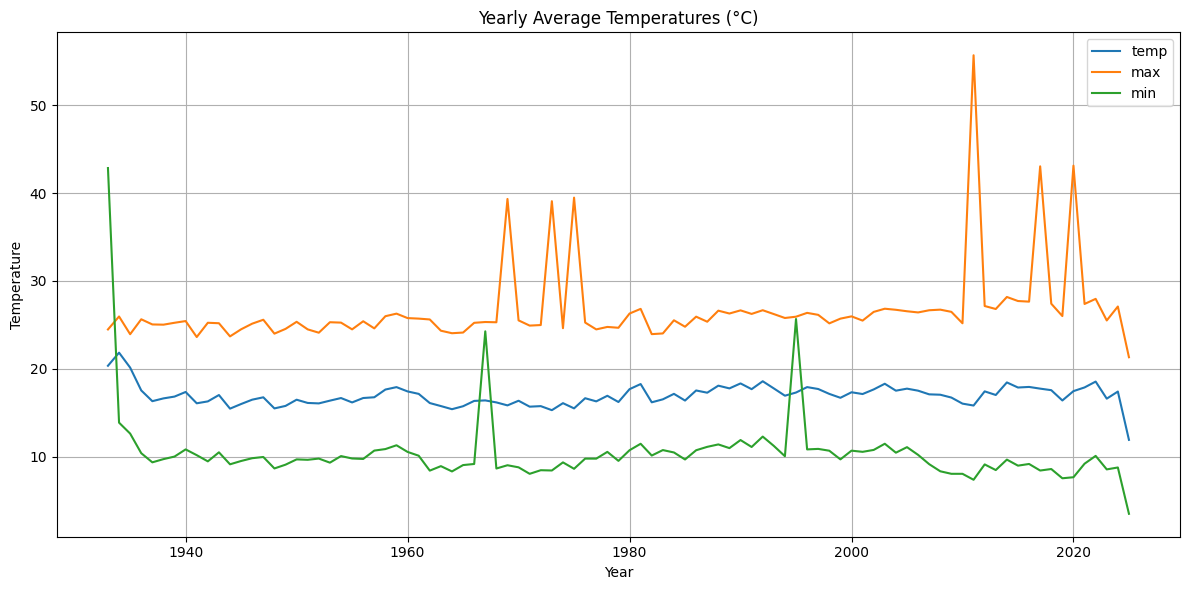

In [ ]:
# Extract year for grouping
df['year'] = df['date'].dt.year

# Group by year and calculate mean
yearly_trends = df.groupby('year')[temp_cols].mean()

# Plot trends
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for col in temp_cols:
    plt.plot(yearly_trends.index, yearly_trends[col], label=col)

plt.title("Yearly Average Temperatures (°C)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
max_outliers = df[df['max'] > 50]
print(max_outliers)

       Unnamed: 0       date   temp      max   min  year
13463       13463 1969-12-15   8.78  5537.72 -2.78  1969
14722       14722 1973-05-27  19.33  5537.72  7.72  1973
15607       15607 1975-10-29  16.56  5537.72  7.22  1975
28815       28815 2011-12-28   8.22  5537.72 -2.50  2011
28818       28818 2011-12-31  11.56  5537.72  1.72  2011
31007       31007 2017-12-28  11.44  5537.72  1.22  2017
32089       32089 2020-12-20   8.89  5537.72 -1.78  2020


In [26]:
min_outliers = df[df['min'] > 50]
print(min_outliers)

       Unnamed: 0       date   temp    max      min  year
7               7 1933-01-08  14.44  23.50  5537.72  1933
164           164 1933-06-14  33.17  38.89  5537.72  1933
12673       12673 1967-10-17  22.61  35.50  5537.72  1967
22929       22929 1995-11-15  11.83  23.78  5537.72  1995


In [37]:
import numpy as np

# Replace outliers with NaN for MAX and MIN
threshold_max = 100   # adjust according to realistic limits for your dataset

df.loc[df['max'] > threshold_max, 'max'] = np.nan
df.loc[df['min'] > threshold_max, 'min'] = np.nan

# Optionally, interpolate missing values
df['max'] = df['max'].interpolate(method='linear')
df['min'] = df['min'].interpolate(method='linear')

# Check the stats to confirm values are now within a realistic range
print(df[['date', 'max', 'min']].describe())


                                date           max  min
count                          33651  33651.000000  0.0
mean   1979-02-25 22:18:40.085584320     25.608117  NaN
min              1933-01-01 00:00:00      3.000000  NaN
25%              1956-02-16 12:00:00     20.000000  NaN
50%              1979-02-28 00:00:00     25.500000  NaN
75%              2002-03-12 12:00:00     31.720000  NaN
max              2025-03-31 00:00:00     46.500000  NaN
std                              NaN      7.414279  NaN


Checking Difference Between Max and Min Temperature Over the Years

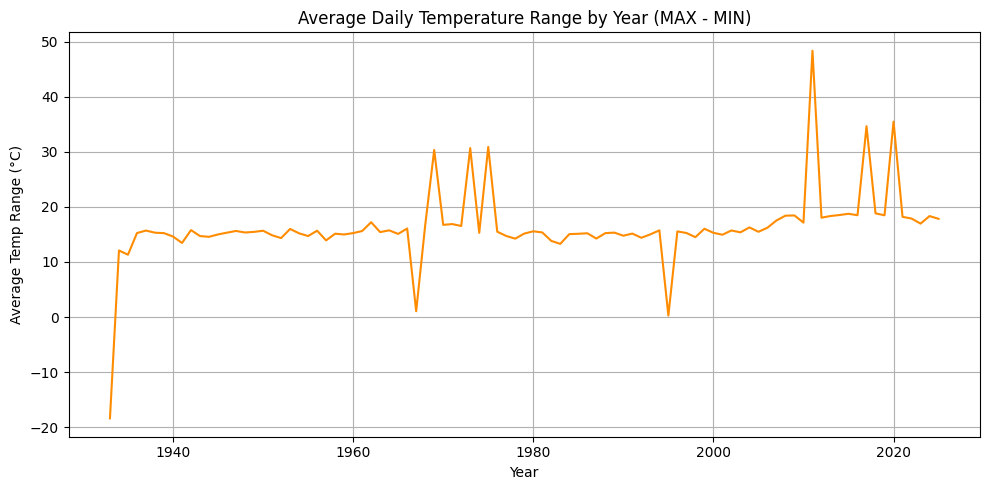

In [28]:
# Add a new column for the daily range
df['temp_range'] = df['max'] - df['min']

# Group by year and calculate average range
temp_range_by_year = df.groupby('year')['temp_range'].mean()

# Plot the average temp range
plt.figure(figsize=(10, 5))
plt.plot(temp_range_by_year.index, temp_range_by_year.values, color='darkorange')
plt.title("Average Daily Temperature Range by Year (MAX - MIN)")
plt.xlabel("Year")
plt.ylabel("Average Temp Range (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


year
1933    361
1934    365
1935    365
1936    366
1937    365
1938    365
1939    365
1940    366
1941    335
1942    365
1943    365
1944    366
1945    365
1946    365
1947    365
1948    366
1949    365
1950    365
1951    365
1952    366
1953    365
1954    365
1955    365
1956    366
1957    365
1958    365
1959    365
1960    366
1961    365
1962    365
1963    365
1964    366
1965    365
1966    365
1967    365
1968    366
1969    365
1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1981    365
1982    365
1983    365
1984    366
1985    365
1986    365
1987    365
1988    366
1989    365
1990    365
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    364
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365

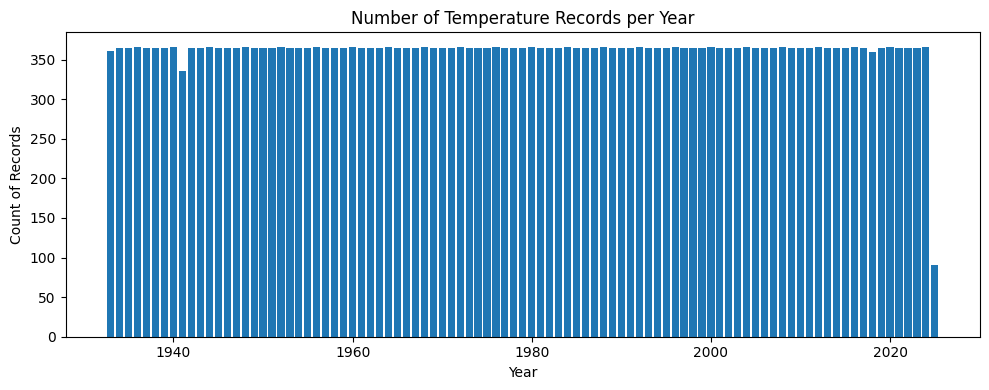

In [35]:
# Count number of measurements per year
freq_by_year = df.groupby('year').size()
print(freq_by_year.to_string())


# Plot number of records per year
plt.figure(figsize=(10, 4))
plt.bar(freq_by_year.index, freq_by_year.values)
plt.title("Number of Temperature Records per Year")
plt.xlabel("Year")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()

### Feature Scaling